In [1]:
from scipy.io import loadmat
#contains indexes of images that can be used for training and validation (Training Validating)   (7368,) 7368 images  (7-10) per person
train_idxs = loadmat('./PR_data/cuhk03_new_protocol_config_labeled.mat')['train_idx'].flatten()

#specifies whether image was taken from camera 1 or camera 2.    
camId = loadmat('./PR_data/cuhk03_new_protocol_config_labeled.mat')['camId'].flatten()

# specifies correspondences between names of files in images_cuhk03 and their indexes
filelist = loadmat('./PR_data/cuhk03_new_protocol_config_labeled.mat')['filelist'].flatten()

#specifies indexes of the part of the dataset from which you compose your ranklists during testing phase (Testing)
gallery_idx = loadmat('./PR_data/cuhk03_new_protocol_config_labeled.mat')['gallery_idx'].flatten()

#contains ground truths for each image                                                           (14096,) 对应着train_idxs的image label
labels = loadmat('./PR_data/cuhk03_new_protocol_config_labeled.mat')['labels'].flatten()

#contains indexes of query images (Testing)
query_idx = loadmat('./PR_data/cuhk03_new_protocol_config_labeled.mat')['query_idx'].flatten()

import sys
print(sys.version)

import json
import numpy as np
with open('feature_data.json', 'r') as f:
    features = json.load(f)
    
feature = np.asarray(features)

y_gallery = np.take(np.array(labels),gallery_idx-1)
X_gallery = np.take(np.array(features),gallery_idx-1,axis = 0)
y_query = np.take(np.array(labels),query_idx-1)
X_query = np.take(np.array(features),query_idx-1,axis = 0)
y_train = np.take(np.array(labels),train_idxs-1)
X_train = np.take(np.array(features),train_idxs-1,axis = 0)

3.6.7 (v3.6.7:6ec5cf24b7, Oct 20 2018, 13:35:33) [MSC v.1900 64 bit (AMD64)]


In [2]:
from sklearn.decomposition import KernelPCA
kPCA = KernelPCA(n_components = 2000, kernel = "cosine")
kPCA.fit(X_train)
X_gallery_kpca = kPCA.transform(X_gallery)
X_query_kpca = kPCA.transform(X_query)

In [3]:
query_feature = []
query_lbl = []
query_camid = []

for i in query_idx:
    query_feature.append(feature[i-1])
    query_lbl.append(labels[i-1])
    query_camid.append(camId[i-1])
    
query_feature = np.asarray(query_feature)
query_lbl = np.asarray(query_lbl)
query_camid = np.asarray(query_camid)

gallery_feature = []
gallery_lbl = []
gallery_camid = []

for i in gallery_idx:
    gallery_feature.append(feature[i-1])
    gallery_lbl.append(labels[i-1])
    gallery_camid.append(camId[i-1])

gallery_feature = np.asarray(gallery_feature)
gallery_lbl = np.asarray(gallery_lbl)
gallery_camid = np.asarray(gallery_camid)
q = X_query_kpca.T
q_combine = (np.vstack((q,query_camid,query_lbl))).T
g = X_gallery_kpca.T
g_combine = (np.vstack( ( g, gallery_camid, gallery_lbl ))).T

In [4]:
def mAP():
    average_precision=[]
    ranklist = np.loadtxt(open("baseline_ranklist.csv", "rb"), delimiter=",")
    for i in range(len(ranklist)):
        precision=[]
        recall=[]
        precisions=[]
        s=sum(ranklist[i,:])
        for j in range(1,ranklist.shape[1]):
            precision.append(sum(ranklist[i,:j]/j))
            recall.append(sum(ranklist[i,:j]/s))
            if recall[j-1] == 1:
                  break

        u=[]
        indices=[]
        recall=np.array(recall)
        precision=np.array(precision)
        u, indices=np.unique(recall,return_index=True)

        precisions=precision[indices]
        precisions=precisions[precisions!=0]
        average_precision.append(np.mean(precisions))
    average_precision = np.nan_to_num(average_precision)
    print('mAP :{}'.format(np.mean(average_precision[1:])))

In [5]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestNeighbors
from tqdm import tqdm

X_train = g_combine[:,:-2]
y_train = g_combine[:,-1]
classifier = NearestNeighbors(n_neighbors=600, metric = 'euclidean')
classifier.fit(X_train, y_train)

query_rank_list_20 = []
acc = []

for i in tqdm(range(q_combine.shape[0])):
    query_lbl = q_combine[i,-1].astype(int)
    X_test = q_combine[i,:-2].reshape(1,-1)
    dist, index = classifier.kneighbors(X_test)
    index = index.flatten()
    ii = 0
    rank_list = []
    for j in index:
        if len(rank_list) < 400:
            if g_combine[j,-1] !=  q_combine[i,-1] or g_combine[j,-2] !=  q_combine[i,-2]:
                rank_list.append(g_combine[j,-1].astype(int) == query_lbl)
    query_rank_list_20.append(rank_list)

query_rank_list_20 = np.asarray(query_rank_list_20)
np.savetxt( 'baseline_ranklist.csv', query_rank_list_20, delimiter= ',' )

rank1 = query_rank_list_20.T[0].T
rank5  = query_rank_list_20.T[ : 5 ].T
rank10 = query_rank_list_20.T[ : 10 ].T

cmc1  = rank1
cmc5  = np.sum(rank5, axis = 1) > 0
cmc10 = np.sum(rank10, axis = 1) > 0

print( 'rank@1: {}%'.format( np.sum(cmc1) / cmc1.shape[ 0 ] * 100 ) )
print( 'rank@5: {}%'.format( np.sum(cmc5) / cmc5.shape[ 0 ] * 100 ) )
print( 'rank@10: {}%'.format( np.sum(cmc10) / cmc10.shape[ 0 ] * 100 ) )

100%|██████████████████████████████████████████████████████████████████████████████| 1400/1400 [00:25<00:00, 54.30it/s]


rank@1: 47.57142857142857%
rank@5: 67.0%
rank@10: 75.07142857142857%


In [6]:
import matplotlib.pyplot as plt
y = []
for i in range(400):
    rank = query_rank_list_20.T[:i+1].T
    cmc = np.sum(rank, axis = 1) > 0
    y.append(np.sum(cmc)/cmc.shape[0]*100)

x = np.arange(1,401)
plt.plot(x,y)
plt.xlabel('Rank')
plt.ylabel('Accuracy')
plt.title("kpca with cosine kernel")
plt.savefig('kpca_cosine.png',format='png', dpi=400, transparent=True)

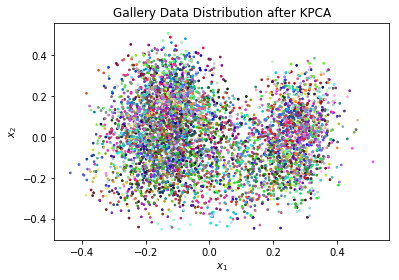

In [7]:
import matplotlib.pyplot as plt
from random import randint
cols = ['#{:06x}'.format(randint(0, 0xffffff)) for i in range(2000)]
pltCol = [cols[int(k)] for k in y_gallery]
# %% Plot 2d PCA data
plt.title('Gallery Data Distribution after KPCA')
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.scatter(X_gallery_kpca[:, 0], X_gallery_kpca[:, 1], color=pltCol,s=3)
plt.savefig('Data_Distribution_after_KPCA.png',format='png', dpi=400, transparent=True)